# Overview

This notebook walks through the process of disaggregating DRB demand data to the nodes of interest. 



In [1]:
# Standard libraries
import numpy as np
import pandas as pd

# Geospatial libraries
import geopandas as gpd

# Data acquisition libraries
from pynhd import NLDI, NHDPlusHR, WaterData

/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Step 0: Load data

Load Pywr-DRB nodes.

Load Pywr-DRB USGS data sources, and unpack the list where multiple gauges are listed for a single node. 


In [2]:
### Load data
# Pywr nodes
nodes = pd.read_csv('../model_data/drb_model_nodes.csv', sep = ',')

# Constants
crs = 4386

In [3]:
def parse_usgs_gauges():
    
    ### Load Pywr gauges
    node_gauges = pd.read_csv(f'../model_data/drb_model_usgs_data_sources.csv', sep = ',')
    crs = 4386
    
    # Flatten the list since multiple sites listed for some nodes
    node_gauge_list = []
    node_names = []
    
    for i, gauge in enumerate(node_gauges.USGS_gages.values):
    
        if type(gauge) == str:
            split = gauge.split(', ')
            for s in split:
                if s[0] != '0':
                    s = f'0{s}'
                node_gauge_list.append(s)
                node_names.append(node_gauges.node.iloc[i])
    node_gauges = pd.DataFrame({'station':node_gauge_list,
                               'node':node_names})
    return node_gauges

In [4]:
node_basins = parse_usgs_gauges()
node_basins

,station,node
0,01425000,reservoir_cannonsville
1,01417000,reservoir_pepacton
2,01429000,reservoir_prompton
3,01432110,reservoir_wallenpaupack
4,01431500,reservoir_wallenpaupack
5,01432495,reservoir_shoholaMarsh
6,01432900,reservoir_mongaupeCombined
7,01436000,reservoir_neversink
8,01449800,reservoir_beltzvilleCombined
9,01447800,reservoir_fewalter


# Step 1: Get basin geometries

Use the station number (with a leading '0') to find each basin.

In [5]:
nldi = NLDI()

n_nodes= len(node_basins.node)

node_basins.index = node_basins.station
node_basins['geometry'] = ''

for i in range(n_nodes):
    station = node_basins.station.iloc[i]
    basin_data = nldi.get_basins(f'{station}')
    node_basins.at[station, 'geometry'] = basin_data.geometry[0]
    
node_basins = gpd.GeoDataFrame(node_basins, geometry=node_basins['geometry'], crs = crs)

In [6]:
node_basins.drop('station', axis=1, inplace=True)
node_basins

,node,geometry
station,,
01425000,reservoir_cannonsville,"POLYGON ((-75.38456 42.05357, -75.39082 42.055..."
01417000,reservoir_pepacton,"POLYGON ((-74.97852 42.05968, -74.98468 42.064..."
01429000,reservoir_prompton,"POLYGON ((-75.37506 41.62698, -75.37673 41.629..."
01432110,reservoir_wallenpaupack,"POLYGON ((-75.34810 41.21746, -75.34580 41.221..."
01431500,reservoir_wallenpaupack,"POLYGON ((-75.18504 41.51156, -75.17393 41.500..."
01432495,reservoir_shoholaMarsh,"POLYGON ((-75.00919 41.29979, -75.00722 41.303..."
01432900,reservoir_mongaupeCombined,"POLYGON ((-74.78192 41.66297, -74.78501 41.678..."
01436000,reservoir_neversink,"POLYGON ((-74.63683 41.78541, -74.63870 41.787..."
01449800,reservoir_beltzvilleCombined,"POLYGON ((-75.64539 40.84277, -75.64731 40.845..."


In [7]:
# Export
node_basins.to_file("./node_basin_geometries.shp")

<AxesSubplot:>

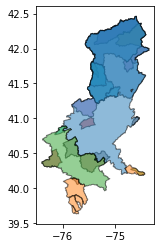

In [8]:
# Visualize
node_basins.plot(column = 'node', edgecolor = 'black', alpha = 0.5)